# 介绍

在现代社会，空气质量的监测和预测是一个至关重要的环境问题，直接关系到公共健康和环境政策制定。随着工业化和城市化的快速发展，空气污染已成为全球许多城市面临的一个严峻挑战。因此，准确预测空气污染物的浓度，特别是在交通繁忙的城市地区，对于制定有效的空气质量管理策略至关重要。本作业利用人工神经网络技术，对意大利某城市道路级别的空气质量数据进行时间序列预测，旨在通过历史数据来预测一氧化碳（CO）和氮氧化物（NOx）的浓度。

本研究所使用的数据集来源于UCI机器学习库，包括从2004年3月至2005年2月，为期一年的、每小时平均的空气质量监测数据。数据由五个金属氧化物化学传感器收集，这些传感器安装在一个空气质量化学多传感器设备中，设备位于该市一个污染严重的地区。数据集包括从这种化学传感器设备中收集的8,358个实例，用于测量该污染区域的空气质量。涵盖的变量包括各种污染物的浓度和传感器的响应，数据集中的缺失值被标记为-200。此外，数据集还包括由位于同一地点的认证分析仪提供的基准小时平均浓度，涵盖了一氧化碳、非甲烷总烃、苯以及总氮氧化物和二氧化氮等污染物。

在进行分析前，数据集需要经过一系列预处理步骤，包括处理缺失值、识别变量的变化范围，并进行适当的数据可视化，以更好地理解各变量之间的关系及其对空气质量的影响。通过这些步骤，我们旨在建立两种神经网络模型：一种用于分类任务，预测CO浓度是否超过设定阈值；另一种用于回归任务，预测NOx的浓度。这两项任务不仅展示了利用人工智能技术处理实际问题的能力，也对我们理解和预测空气质量变化提供了宝贵的见解。

通过这个分析项目，我们期待能够深入探索神经网络在环境科学领域的应用，特别是在处理复杂和非线性的环境数据时，展示其预测空气污染物浓度的潜力。这不仅有助于环境科学家和政策制定者更好地理解和预测空气质量变化，也为使用机器学习技术解决环境问题提供了一个范例。

# 数据预处理

In [1]:
# 避免输出无意义的warming message
import warnings
warnings.filterwarnings('ignore')

首先导入数据集：

In [2]:
import numpy as np
import pandas as pd

In [3]:
file_path = 'AirQualityUCI _ Students.xlsx'

air_quality_data = pd.read_excel(file_path)

查看一下数据集的前几行数据：

In [4]:
air_quality_data.head()

,Date,Time,CO(GT),PT08.S1(CO),NMHC(GT),C6H6(GT),PT08.S2(NMHC),NOx(GT),PT08.S3(NOx),NO2(GT),PT08.S4(NO2),PT08.S5(O3),T,RH,AH
0,2004-03-10,18:00:00,2.6,1360.00,150,11.881723,1045.50,166.0,1056.25,113.0,1692.00,1267.50,13.60,48.875001,0.757754
1,2004-03-10,19:00:00,2.0,1292.25,112,9.397165,954.75,103.0,1173.75,92.0,1558.75,972.25,13.30,47.700000,0.725487
2,2004-03-10,20:00:00,2.2,1402.00,88,8.997817,939.25,131.0,1140.00,114.0,1554.50,1074.00,11.90,53.975000,0.750239
3,2004-03-10,21:00:00,2.2,1375.50,80,9.228796,948.25,172.0,1092.00,122.0,1583.75,1203.25,11.00,60.000000,0.786713
4,2004-03-10,22:00:00,1.6,1272.25,51,6.518224,835.50,131.0,1205.00,116.0,1490.00,1110.00,11.15,59.575001,0.788794


然后检测一下每个特征的类型：

In [5]:
air_quality_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8358 entries, 0 to 8357
Data columns (total 15 columns):
 #   Column         Non-Null Count  Dtype         
---  ------         --------------  -----         
 0   Date           8358 non-null   datetime64[ns]
 1   Time           8358 non-null   object        
 2   CO(GT)         8358 non-null   float64       
 3   PT08.S1(CO)    8358 non-null   float64       
 4   NMHC(GT)       8358 non-null   int64         
 5   C6H6(GT)       8358 non-null   float64       
 6   PT08.S2(NMHC)  8358 non-null   float64       
 7   NOx(GT)        8358 non-null   float64       
 8   PT08.S3(NOx)   8358 non-null   float64       
 9   NO2(GT)        8358 non-null   float64       
 10  PT08.S4(NO2)   8358 non-null   float64       
 11  PT08.S5(O3)    8358 non-null   float64       
 12  T              8358 non-null   float64       
 13  RH             8358 non-null   float64       
 14  AH             8358 non-null   float64       
dtypes: datetime64[ns](1),

从结果上可以发现，数据集的每个变量都不存在着NaN表示的缺失值，也就是说每个列的每一行都有数据记录。

## 数据缺失值处理

接着查看一下缺失值的分布情况，缺失值根据数据集的描述，使用-200进行表示：

In [6]:
import matplotlib.pyplot as plt
import seaborn as sns

%matplotlib inline

In [7]:
# Let's use an alternative method to replace -200 with NaN to avoid recursion issues
air_quality_data = air_quality_data.applymap(lambda x: pd.NA if x == -200 else x)

# Calculate missing values and their percentage again
missing_data = air_quality_data.isna().sum()
missing_percentage = (missing_data / len(air_quality_data)) * 100

# Prepare a DataFrame for visualization again
missing_df = pd.DataFrame({
    'Missing Values': missing_data,
    'Percentage': missing_percentage
})

# Display missing values count and percentage
print(missing_df)

               Missing Values  Percentage
Date                        0    0.000000
Time                        0    0.000000
CO(GT)                   1585   18.963867
PT08.S1(CO)               366    4.379038
NMHC(GT)                 7525   90.033501
C6H6(GT)                  366    4.379038
PT08.S2(NMHC)             366    4.379038
NOx(GT)                  1573   18.820292
PT08.S3(NOx)              366    4.379038
NO2(GT)                  1576   18.856186
PT08.S4(NO2)              366    4.379038
PT08.S5(O3)               366    4.379038
T                         366    4.379038
RH                        366    4.379038
AH                        366    4.379038


也可以进行可视化进行表示：

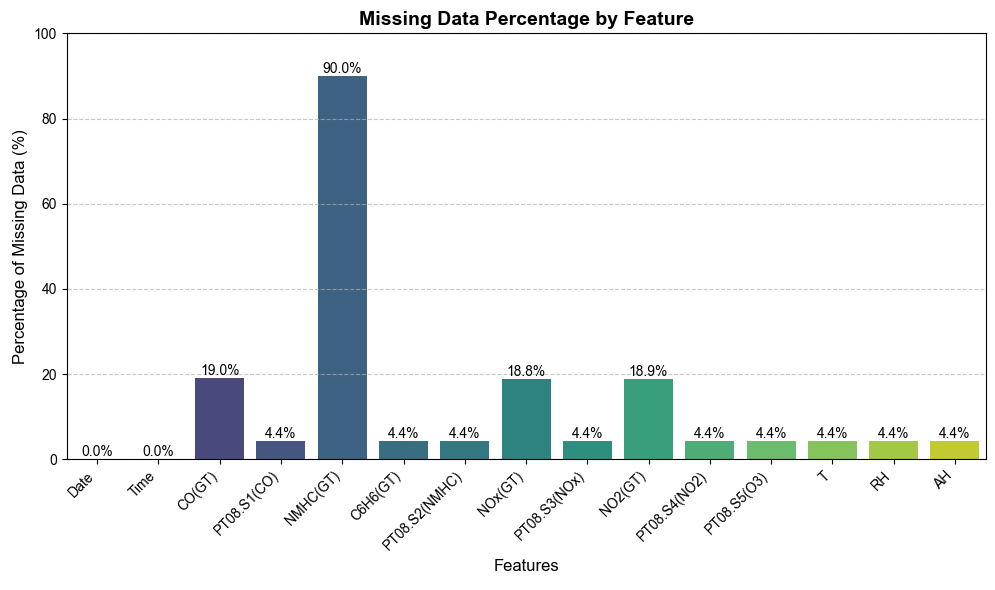

In [8]:
# Visualization of missing data with improved aesthetics
plt.figure(figsize=(10, 6))
ax = sns.barplot(x=missing_df.index, y=missing_df['Percentage'], palette='viridis')

plt.xticks(rotation=45, ha='right')
plt.ylabel('Percentage of Missing Data (%)', fontsize=12)
plt.xlabel('Features', fontsize=12)
plt.title('Missing Data Percentage by Feature', fontsize=14, fontweight='bold')

# Add value labels on top of each bar
for i, v in enumerate(missing_df['Percentage']):
    ax.text(i, v, f'{v:.1f}%', ha='center', va='bottom')

# Adjust layout and display grid
plt.tight_layout()
plt.grid(axis='y', linestyle='--', alpha=0.7)

# Improve overall style
sns.set_style("whitegrid")
plt.ylim(0, 100)  # Set y-axis limit from 0 to 100%

plt.show()

从可视化的结果可以发现：

- NMHC(GT)：这个变量的缺失值占比高达90.0%，因此可以认为该变量需要被直接删除
- CO(GT)，NOx(GT)和NO2(GT)：这三个变量的缺失值接近于20%，需要进行填充处理
- Date和Time：这两个变量不存在着缺失值，不需要进行任何的处理
- 其他的变量：其他的变量普遍存在着4.4%左右的缺失值，可以直接删除或者进行填充处理

In [9]:
# 首先删除NMHC(GT)
air_quality_data_cleaned = air_quality_data.drop(columns=['NMHC(GT)'])

对于其他的变量，采用的思路为：

- 如果缺失值的出现是连续的（连续出现超过3个），则直接删除所在的行
- 如果缺失值的出现是单个的，则使用窗口平滑，窗口的大小为5（如果其中有一个是缺失值，则不考虑这个值）

In [10]:
def remove_rows_with_consecutive_nans(data, max_consec_nans=2):
    # Create a mask to identify rows to keep
    mask = pd.Series(True, index=data.index)
    
    # Check each column for consecutive NaNs
    for column in data.columns:
        # Find consecutive NaNs
        consec_nans = data[column].isna().astype(int).groupby(data[column].notna().cumsum()).cumsum()
        # Find where consecutive NaNs exceed max_consec_nans
        over_limit = consec_nans > max_consec_nans
        # Mark rows for deletion
        for idx in over_limit[over_limit].index:
            # Calculate the start and end of the NaN sequence
            start_idx = idx - consec_nans.loc[idx] + 1
            end_idx = idx
            # Update mask
            mask.loc[start_idx:end_idx] = False
    
    # Filter the data
    return data[mask]

# Apply the adjusted function to the dataset
air_quality_filtered = remove_rows_with_consecutive_nans(air_quality_data_cleaned)

In [11]:
# 查看删除了多少行
# Display how many rows were removed after correction
original_row_count = len(air_quality_data_cleaned)
filtered_row_count  = len(air_quality_filtered )
rows_removed  = original_row_count  - filtered_row_count 

original_row_count , filtered_row_count , rows_removed

(8358, 6456, 1902)

经过修正后的处理，我们成功删除了包含连续超过3个缺失值的行(包括3个)，共删除了1902行。剩余数据共有6456行。

In [12]:
# Calculate missing values for each feature in the smoothed dataset directly
smoothed_missing_data_direct = air_quality_filtered.isna().sum()
smoothed_missing_percentage_direct = (smoothed_missing_data_direct / len(air_quality_filtered)) * 100

# Prepare a DataFrame for visualization of direct missing data check
smoothed_missing_df_direct = pd.DataFrame({
    'Missing Values': smoothed_missing_data_direct,
    'Percentage': smoothed_missing_percentage_direct
})

# Display the updated missing values count and percentage directly
smoothed_missing_df_direct

,Missing Values,Percentage
Date,0,0.000000
Time,0,0.000000
CO(GT),135,2.091078
PT08.S1(CO),2,0.030979
C6H6(GT),2,0.030979
PT08.S2(NMHC),2,0.030979
NOx(GT),260,4.027261
PT08.S3(NOx),2,0.030979
NO2(GT),262,4.058240
PT08.S4(NO2),2,0.030979


接下来，我们将处理那些仅有单个缺失值的情况。

由于先前使用了NaN来替换-200，导致了一些原本的数值型变量中存在着NaN这种数据，从而导致该特征的数据类型的改变，所以在计算之前先要将数据类型修改回去：

In [13]:
air_quality_filtered.info()   # 现在的情况

<class 'pandas.core.frame.DataFrame'>
Index: 6456 entries, 0 to 8357
Data columns (total 14 columns):
 #   Column         Non-Null Count  Dtype         
---  ------         --------------  -----         
 0   Date           6456 non-null   datetime64[ns]
 1   Time           6456 non-null   object        
 2   CO(GT)         6321 non-null   object        
 3   PT08.S1(CO)    6454 non-null   object        
 4   C6H6(GT)       6454 non-null   object        
 5   PT08.S2(NMHC)  6454 non-null   object        
 6   NOx(GT)        6196 non-null   object        
 7   PT08.S3(NOx)   6454 non-null   object        
 8   NO2(GT)        6194 non-null   object        
 9   PT08.S4(NO2)   6454 non-null   object        
 10  PT08.S5(O3)    6454 non-null   object        
 11  T              6454 non-null   object        
 12  RH             6454 non-null   object        
 13  AH             6454 non-null   object        
dtypes: datetime64[ns](1), object(13)
memory usage: 756.6+ KB


对于这些单个缺失值，我们将使用窗口大小为5的平滑方法进行填充。

如果窗口中有缺失值，则不考虑这个值进行平均。

In [14]:
def fill_single_nans_all_columns(data, window_size=5):
    # Iterate over all columns, excluding explicitly non-numeric columns like 'Date' and 'Time'
    for column in data.columns:
        # Skip 'Date' and 'Time' columns if present
        if column in ['Date', 'Time']:
            continue
        else:
            # Attempt to convert the column to numeric if it's not already (helps with columns that might be read as 'object' type due to NaNs)
            data[column] = pd.to_numeric(data[column], errors='coerce')
            # Apply a centered rolling window, calculate mean
            rolling_means = data[column].rolling(window=window_size, min_periods=1, center=True).mean()
            # Fill NaNs with the rolling means
            data[column] = data[column].fillna(value=rolling_means)
    return data

# Assuming 'air_quality_filtered' is your dataframe loaded from the Excel file and already preprocessed to replace -200 with NaN
air_quality_smoothed = fill_single_nans_all_columns(air_quality_filtered.copy())

接着查看一下现在的缺失值的情况：

In [15]:
# Calculate missing values for each feature in the smoothed dataset directly
smoothed_missing_data_direct = air_quality_smoothed.isna().sum()
smoothed_missing_percentage_direct = (smoothed_missing_data_direct / len(air_quality_smoothed)) * 100

# Prepare a DataFrame for visualization of direct missing data check
smoothed_missing_df_direct = pd.DataFrame({
    'Missing Values': smoothed_missing_data_direct,
    'Percentage': smoothed_missing_percentage_direct
})

# Display the updated missing values count and percentage directly
smoothed_missing_df_direct

,Missing Values,Percentage
Date,0,0.0
Time,0,0.0
CO(GT),0,0.0
PT08.S1(CO),0,0.0
C6H6(GT),0,0.0
PT08.S2(NMHC),0,0.0
NOx(GT),0,0.0
PT08.S3(NOx),0,0.0
NO2(GT),0,0.0
PT08.S4(NO2),0,0.0


至此，所有的缺失值情况都已经被处理。

In [16]:
air_quality_smoothed.info()

<class 'pandas.core.frame.DataFrame'>
Index: 6456 entries, 0 to 8357
Data columns (total 14 columns):
 #   Column         Non-Null Count  Dtype         
---  ------         --------------  -----         
 0   Date           6456 non-null   datetime64[ns]
 1   Time           6456 non-null   object        
 2   CO(GT)         6456 non-null   float64       
 3   PT08.S1(CO)    6456 non-null   float64       
 4   C6H6(GT)       6456 non-null   float64       
 5   PT08.S2(NMHC)  6456 non-null   float64       
 6   NOx(GT)        6456 non-null   float64       
 7   PT08.S3(NOx)   6456 non-null   float64       
 8   NO2(GT)        6456 non-null   float64       
 9   PT08.S4(NO2)   6456 non-null   float64       
 10  PT08.S5(O3)    6456 non-null   float64       
 11  T              6456 non-null   float64       
 12  RH             6456 non-null   float64       
 13  AH             6456 non-null   float64       
dtypes: datetime64[ns](1), float64(12), object(1)
memory usage: 756.6+ KB


In [17]:
# 将Time列转换为datetime.time类型
air_quality_smoothed['Time'] = pd.to_datetime(air_quality_smoothed['Time'], format='%H:%M:%S').dt.time

In [18]:
# 检查更改后的数据类型
air_quality_smoothed.info()

<class 'pandas.core.frame.DataFrame'>
Index: 6456 entries, 0 to 8357
Data columns (total 14 columns):
 #   Column         Non-Null Count  Dtype         
---  ------         --------------  -----         
 0   Date           6456 non-null   datetime64[ns]
 1   Time           6456 non-null   object        
 2   CO(GT)         6456 non-null   float64       
 3   PT08.S1(CO)    6456 non-null   float64       
 4   C6H6(GT)       6456 non-null   float64       
 5   PT08.S2(NMHC)  6456 non-null   float64       
 6   NOx(GT)        6456 non-null   float64       
 7   PT08.S3(NOx)   6456 non-null   float64       
 8   NO2(GT)        6456 non-null   float64       
 9   PT08.S4(NO2)   6456 non-null   float64       
 10  PT08.S5(O3)    6456 non-null   float64       
 11  T              6456 non-null   float64       
 12  RH             6456 non-null   float64       
 13  AH             6456 non-null   float64       
dtypes: datetime64[ns](1), float64(12), object(1)
memory usage: 756.6+ KB


至此，数据的缺失值和类型处理全部完成。

## 数据探索

为了方便，可以先将处理之后的数据导出来，然后再重新导入。

In [19]:
output_file_path = 'AirQualityUCI_NoNaN.csv'

air_quality_smoothed.to_csv(output_file_path, index=False)

In [20]:
file_path = 'AirQualityUCI_NoNaN.csv'

# 读取CSV文件到DataFrame
air_quality_processed = pd.read_csv(file_path)

# 检查数据框的信息以确认读取成功
air_quality_processed.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6456 entries, 0 to 6455
Data columns (total 14 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   Date           6456 non-null   object 
 1   Time           6456 non-null   object 
 2   CO(GT)         6456 non-null   float64
 3   PT08.S1(CO)    6456 non-null   float64
 4   C6H6(GT)       6456 non-null   float64
 5   PT08.S2(NMHC)  6456 non-null   float64
 6   NOx(GT)        6456 non-null   float64
 7   PT08.S3(NOx)   6456 non-null   float64
 8   NO2(GT)        6456 non-null   float64
 9   PT08.S4(NO2)   6456 non-null   float64
 10  PT08.S5(O3)    6456 non-null   float64
 11  T              6456 non-null   float64
 12  RH             6456 non-null   float64
 13  AH             6456 non-null   float64
dtypes: float64(12), object(2)
memory usage: 706.3+ KB


首先查看一下统计描述的结果：

In [21]:
air_quality_processed.describe()

,CO(GT),PT08.S1(CO),C6H6(GT),PT08.S2(NMHC),NOx(GT),PT08.S3(NOx),NO2(GT),PT08.S4(NO2),PT08.S5(O3),T,RH,AH
count,6456.000000,6456.000000,6456.000000,6456.000000,6456.000000,6456.000000,6456.000000,6456.000000,6456.000000,6456.000000,6456.000000,6456.000000
mean,2.102523,1103.315840,10.181724,942.498351,241.351101,831.401564,110.953764,1440.460908,1040.490351,17.502015,49.334624,0.985310
std,1.433170,217.513683,7.471830,268.054860,206.955345,260.683964,48.527242,353.610819,409.688764,8.974987,17.234761,0.409013
min,0.100000,647.250000,0.164946,386.750000,6.000000,322.000000,2.000000,551.000000,221.000000,-1.900000,9.175000,0.184679
25%,1.000000,938.187500,4.458207,735.500000,94.500000,649.750000,74.000000,1192.000000,739.125000,10.618750,36.200000,0.678538
50%,1.800000,1069.000000,8.363172,914.000000,178.000000,796.500000,107.000000,1441.875000,985.500000,16.700000,49.575001,0.949637
75%,2.800000,1238.250000,14.239754,1124.375000,322.475000,967.500000,139.700000,1671.562500,1302.375000,23.625000,62.625000,1.275608
max,11.900000,2007.750000,63.741476,2214.000000,1479.000000,2682.750000,332.600000,2775.000000,2522.750000,44.600000,87.074999,2.180639


数据集中包含了6456条记录，涵盖了多种空气质量指标和环境变量。这些变量包括一氧化碳（CO）的真实浓度及其传感器读数、苯（C6H6）的真实浓度及其传感器读数、氮氧化物（NOx）的真实浓度及其传感器读数、二氧化氮（NO2）的真实浓度及其传感器读数、臭氧（O3）的传感器读数、温度（T）、相对湿度（RH）和绝对湿度（AH）。

首先，一氧化碳（CO）的真实浓度（CO(GT)）的平均值为2.10，标准差为1.43，表明大多数记录的CO浓度在0.67到3.53之间波动。最小值为0.1，最大值为11.9，这表示在某些时段，CO浓度显著高于平均水平。与之对应的传感器读数（PT08.S1(CO)）的均值为1103.32，标准差为217.51，这表明传感器读数相对稳定，但仍存在一定波动。

苯（C6H6）的真实浓度的均值为10.18，标准差为7.47，显示出较大的波动范围，可能受环境中其他污染物或外部因素的影响。苯的最小值为0.16，最大值为63.74，表明在特定时间点苯的浓度可以非常高。

氮氧化物（NOx）的真实浓度（NOx(GT)）和传感器读数（PT08.S3(NOx)）的均值分别为241.35和831.40，标准差分别为206.96和260.68。NOx的最小值为6，最大值为1479，这些数值显示了显著的波动，说明在某些情况下，污染物浓度可能急剧上升。

二氧化氮（NO2）的真实浓度（NO2(GT)）的均值为110.95，标准差为48.53，表明在大多数记录中，NO2的浓度相对较低，但有时也会出现较高的浓度，最高可达332.6。

传感器读数PT08.S4(NO2)和PT08.S5(O3)的均值分别为1440.46和1040.49，显示出传感器的读数在这些变量中的变化范围较广。

温度（T）的均值为17.50度，标准差为8.97度，显示了温度的季节性波动，最低温度为-1.9度，最高温度为44.6度。相对湿度（RH）的均值为49.33，标准差为17.23，表明湿度也有显著波动，范围从9.18%到87.07%。绝对湿度（AH）的均值为0.99，标准差为0.41，表示空气中水汽含量的变化。

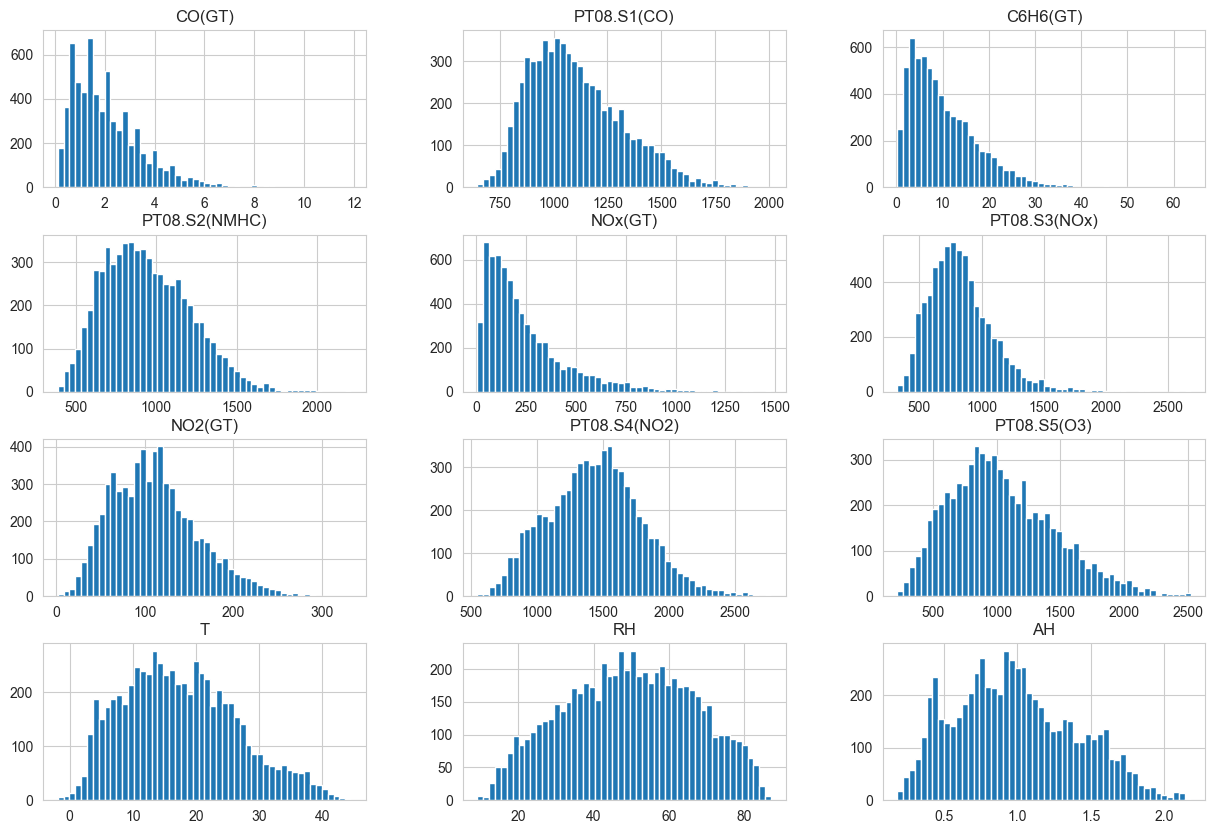

In [22]:
import matplotlib.pyplot as plt

# 绘制直方图
air_quality_processed.hist(bins=50, figsize=(15, 10))
plt.show()

这些直方图展示了空气质量指标和环境变量的分布情况。每个变量的分布特点揭示了数据在特定范围内的集中趋势以及一些潜在的异常值。

首先，一氧化碳（CO）的真实浓度（CO(GT)）呈现右偏分布。大多数数据集中在0到4的范围内，峰值在1到2之间。这表明大多数时间段内CO的浓度较低，但有一些高浓度的记录，这些记录虽然较少，但仍然值得注意，因为它们可能对空气质量有显著影响。

一氧化碳传感器的响应值（PT08.S1(CO)）集中在800到1500之间，呈现出钟形分布，峰值大约在1100左右。这表明传感器在检测CO时的响应值较为稳定，集中在一个特定范围内。

苯（C6H6）的真实浓度（C6H6(GT)）也呈现右偏分布，峰值在0到10之间，大多数数据低于20。然而，存在一些高浓度的记录，最大值达到60以上，这些高值记录可能是由于特定污染源或事件引起的。

非甲烷烃（NMHC）的传感器响应值（PT08.S2(NMHC)）主要集中在500到1500之间，呈现出钟形分布，峰值在900左右。这个分布表明传感器对NMHC的检测在大多数情况下是相对一致的。

氮氧化物（NOx）的真实浓度（NOx(GT)）同样呈现右偏分布，大多数数据集中在0到500之间，峰值在100左右。存在一些高浓度的记录，最高值接近1500，这可能是由于交通拥堵或工业排放等因素导致的。

氮氧化物传感器的响应值（PT08.S3(NOx)）集中在500到1500之间，呈钟形分布，峰值在800左右，这表明传感器对NOx的检测较为可靠，且数据集中在特定范围内。

二氧化氮（NO2）的真实浓度（NO2(GT)）分布类似于NOx，右偏分布，大多数数据集中在0到200之间，峰值在100左右。这个分布显示了在大多数情况下，NO2的浓度较低，但也存在一些较高的浓度记录。

二氧化氮传感器的响应值（PT08.S4(NO2)）集中在1000到2000之间，呈现出钟形分布，峰值在1500左右，这表明传感器对NO2的检测在大多数情况下是相对一致的。

臭氧传感器的响应值（PT08.S5(O3)）集中在500到1500之间，呈现出钟形分布，峰值在1000左右。这个分布表明传感器在检测臭氧时的响应值较为稳定。

温度（T）的分布呈现出钟形分布，范围从-5到45度，峰值在15到25度之间。这表明温度在这个范围内波动较大，且中间温度范围的数据最多。

相对湿度（RH）的分布呈现双峰分布，两个主要峰值在30到40和60到70之间。这表明在这些范围内，相对湿度的变化较为频繁。

绝对湿度（AH）的分布也呈现双峰分布，两个主要峰值在0.5到1和1到1.5之间。这表明在这些范围内，空气中的水汽含量变化较为显著。

总体而言，大多数空气质量指标和环境变量显示出一定的偏度和峰度，部分变量如CO(GT)、C6H6(GT)、NOx(GT)和NO2(GT)显示出右偏分布，而温度、相对湿度和绝对湿度则展示了更为复杂的多峰分布。这些分布特点为进一步的分析和建模提供了重要的信息。

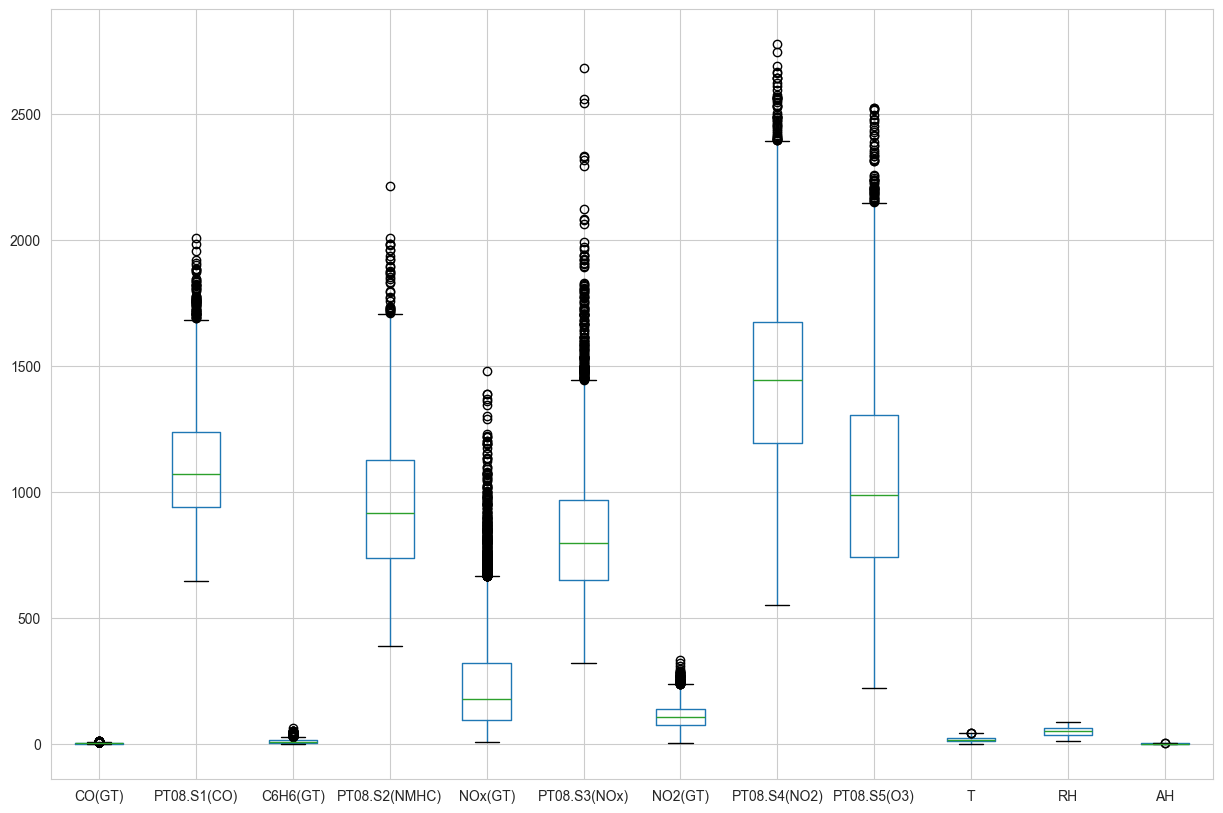

In [23]:
# 绘制箱线图
air_quality_processed.boxplot(figsize=(15, 10))
plt.show()

这个箱线图展示了各空气质量指标和环境变量的分布和离群值情况。箱线图中，每个变量的中位数由箱体内的绿色线表示，箱体的上下边缘分别代表数据的第25百分位数和第75百分位数，箱体之外的延伸线（须）表示数据的范围，而图中的圆圈表示离群值。

从图中可以看出，大多数空气质量指标（如CO(GT)、NOx(GT)和NO2(GT)）和传感器响应值（如PT08.S1(CO)、PT08.S2(NMHC)等）都存在大量的离群值，特别是上边缘的离群值较多，表明这些变量在高值范围内有显著的异常点。环境变量如温度（T）、相对湿度（RH）和绝对湿度（AH）的离群值较少，分布相对集中，显示出更为稳定的变化趋势。总体来看，箱线图揭示了数据集中不同变量的集中趋势和异常值情况，有助于进一步分析和处理这些数据。

## 相关性分析

查看一下相关性的情况：

In [24]:
# 确保计算相关性矩阵时不包括日期和时间列
correlation_matrix = air_quality_processed.drop(['Date', 'Time'], axis=1).corr()

In [25]:
correlation_matrix

,CO(GT),PT08.S1(CO),C6H6(GT),PT08.S2(NMHC),NOx(GT),PT08.S3(NOx),NO2(GT),PT08.S4(NO2),PT08.S5(O3),T,RH,AH
CO(GT),1.000000,0.879705,0.926867,0.911603,0.791732,-0.718834,0.686010,0.614516,0.853051,0.030079,0.036100,0.048426
PT08.S1(CO),0.879705,1.000000,0.879968,0.889938,0.729324,-0.791499,0.651880,0.656198,0.899645,0.036796,0.154750,0.142568
C6H6(GT),0.926867,0.879968,1.000000,0.981892,0.725691,-0.743625,0.616395,0.751291,0.859924,0.204044,-0.048947,0.181607
PT08.S2(NMHC),0.911603,0.889938,0.981892,1.000000,0.712657,-0.805322,0.648981,0.762026,0.876506,0.242098,-0.074670,0.197332
NOx(GT),0.791732,0.729324,0.725691,0.712657,1.000000,-0.676760,0.771330,0.226446,0.800928,-0.263588,0.191542,-0.164968
PT08.S3(NOx),-0.718834,-0.791499,-0.743625,-0.805322,-0.676760,1.000000,-0.661003,-0.522058,-0.815000,-0.110380,-0.107378,-0.216415
NO2(GT),0.686010,0.651880,0.616395,0.648981,0.771330,-0.661003,1.000000,0.144661,0.715845,-0.205516,-0.094261,-0.355856
PT08.S4(NO2),0.614516,0.656198,0.751291,0.762026,0.226446,-0.522058,0.144661,1.000000,0.557359,0.596644,-0.028962,0.660122
PT08.S5(O3),0.853051,0.899645,0.859924,0.876506,0.800928,-0.815000,0.715845,0.557359,1.000000,-0.031129,0.141982,0.068022
T,0.030079,0.036796,0.204044,0.242098,-0.263588,-0.110380,-0.205516,0.596644,-0.031129,1.000000,-0.554152,0.680831


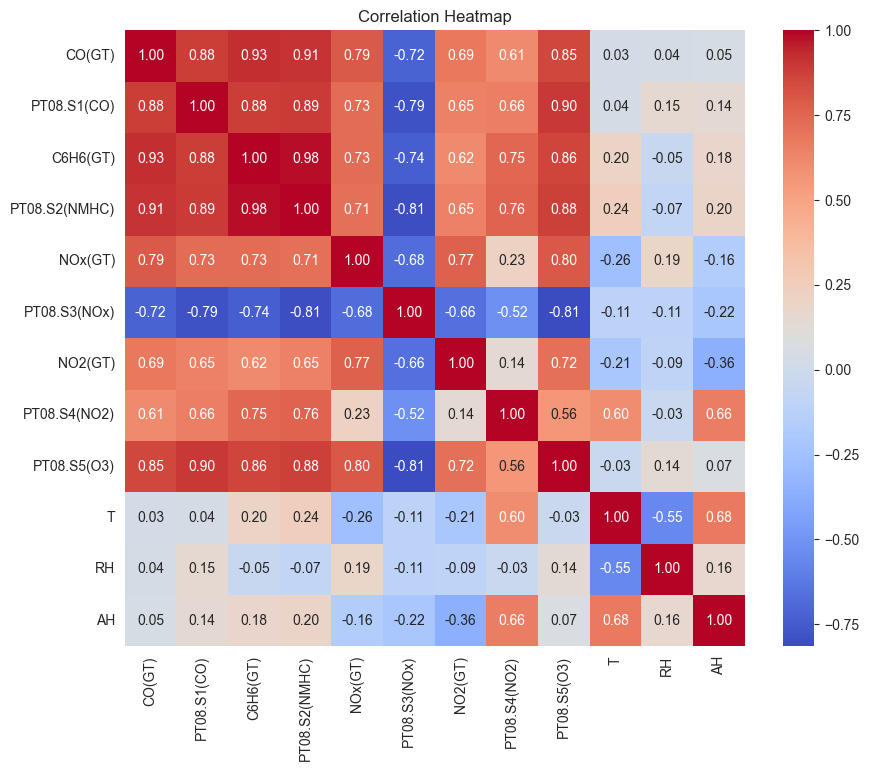

In [26]:
# 绘制热力图
plt.figure(figsize=(10, 8))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt=".2f")
plt.title('Correlation Heatmap')
plt.show()

在你的数据中，可以考虑使用0.7作为阈值，来看哪些变量之间的相关性较高。以下是相关性绝对值大于0.7的变量对：

1. **CO(GT) 和 PT08.S1(CO)**：相关系数为0.88
2. **CO(GT) 和 C6H6(GT)**：相关系数为0.93
3. **CO(GT) 和 PT08.S2(NMHC)**：相关系数为0.91
4. **CO(GT) 和 NOx(GT)**：相关系数为0.79
5. **CO(GT) 和 PT08.S5(O3)**：相关系数为0.85
6. **PT08.S1(CO) 和 C6H6(GT)**：相关系数为0.88
7. **PT08.S1(CO) 和 PT08.S2(NMHC)**：相关系数为0.89
8. **PT08.S1(CO) 和 PT08.S5(O3)**：相关系数为0.90
9. **C6H6(GT) 和 PT08.S2(NMHC)**：相关系数为0.98
10. **C6H6(GT) 和 PT08.S5(O3)**：相关系数为0.86
11. **PT08.S2(NMHC) 和 PT08.S5(O3)**：相关系数为0.88
12. **NOx(GT) 和 NO2(GT)**：相关系数为0.77
13. **PT08.S3(NOx) 和 PT08.S5(O3)**：相关系数为-0.82

从上面的列表中可以看到，变量之间的相关性较高，尤其是CO(GT)与其他污染物（如C6H6(GT)和PT08.S2(NMHC)）之间的相关性非常高。此外，传感器读数之间也显示出较高的相关性，这表明它们可能响应于相似的环境条件或污染物浓度。

为了减少多重共线性并简化模型，可以删除一些高度相关的变量，保留最能代表其他变量信息的少数几个。基于相关性矩阵和相关系数的分析，我们可以选择保留一些代表性变量，删除与其高度相关的变量。以下是步骤：

1. **选择代表性变量**：选择那些在分析和模型中最重要或最感兴趣的变量，尽量保留它们。
2. **删除高度相关的变量**：对于与代表性变量高度相关的变量，删除它们以减少冗余信息。

基于相关性分析，可以考虑以下保留和删除方案：

- **保留CO(GT)**：删除与其高度相关的变量。
  - 删除PT08.S1(CO)（相关系数0.88）
  - 删除C6H6(GT)（相关系数0.93）
  - 删除PT08.S2(NMHC)（相关系数0.91）
  - 删除PT08.S5(O3)（相关系数0.85）

- **保留NOx(GT)**：删除与其高度相关的变量。
  - 删除NO2(GT)（相关系数0.77）

- **保留PT08.S3(NOx)**：删除与其高度相关的变量。
  - 删除PT08.S5(O3)（相关系数-0.82）

- **保留其他重要变量**：例如，T（温度）、RH（相对湿度）、AH（绝对湿度）等。

下面是一个简化的变量选择方案：

- 保留：CO(GT), NOx(GT), PT08.S3(NOx), T, RH, AH
- 删除：PT08.S1(CO), C6H6(GT), PT08.S2(NMHC), PT08.S5(O3), NO2(GT)

In [27]:
# 保留的变量列表
variables_to_keep = ['CO(GT)', 'NOx(GT)', 'PT08.S3(NOx)', 'T', 'RH', 'AH', 'Date', 'Time']

# 创建一个新的数据框，只保留选定的变量
air_quality_reduced = air_quality_processed[variables_to_keep]

In [28]:
# 检查新的数据框信息
air_quality_reduced.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6456 entries, 0 to 6455
Data columns (total 8 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   CO(GT)        6456 non-null   float64
 1   NOx(GT)       6456 non-null   float64
 2   PT08.S3(NOx)  6456 non-null   float64
 3   T             6456 non-null   float64
 4   RH            6456 non-null   float64
 5   AH            6456 non-null   float64
 6   Date          6456 non-null   object 
 7   Time          6456 non-null   object 
dtypes: float64(6), object(2)
memory usage: 403.6+ KB


对Date进行额外的处理：

In [29]:
# 提取年、月、日、星期几、季度等
air_quality_reduced['Date'] = pd.to_datetime(air_quality_reduced['Date'])

air_quality_reduced['Year'] = air_quality_reduced['Date'].dt.year
air_quality_reduced['Month'] = air_quality_reduced['Date'].dt.month
air_quality_reduced['Day'] = air_quality_reduced['Date'].dt.day

In [30]:
air_quality_reduced.drop('Date', axis=1, inplace=True)

In [31]:
air_quality_reduced.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6456 entries, 0 to 6455
Data columns (total 10 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   CO(GT)        6456 non-null   float64
 1   NOx(GT)       6456 non-null   float64
 2   PT08.S3(NOx)  6456 non-null   float64
 3   T             6456 non-null   float64
 4   RH            6456 non-null   float64
 5   AH            6456 non-null   float64
 6   Time          6456 non-null   object 
 7   Year          6456 non-null   int32  
 8   Month         6456 non-null   int32  
 9   Day           6456 non-null   int32  
dtypes: float64(6), int32(3), object(1)
memory usage: 428.8+ KB


Time则只需要保留小时就可以了：

In [32]:
air_quality_reduced['Hour'] = pd.to_datetime(air_quality_reduced['Time'], format='%H:%M:%S').dt.hour

In [33]:
air_quality_reduced.drop('Time', axis=1, inplace=True)

In [34]:
air_quality_reduced.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6456 entries, 0 to 6455
Data columns (total 10 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   CO(GT)        6456 non-null   float64
 1   NOx(GT)       6456 non-null   float64
 2   PT08.S3(NOx)  6456 non-null   float64
 3   T             6456 non-null   float64
 4   RH            6456 non-null   float64
 5   AH            6456 non-null   float64
 6   Year          6456 non-null   int32  
 7   Month         6456 non-null   int32  
 8   Day           6456 non-null   int32  
 9   Hour          6456 non-null   int32  
dtypes: float64(6), int32(4)
memory usage: 403.6 KB


In [35]:
air_quality_reduced.head()

,CO(GT),NOx(GT),PT08.S3(NOx),T,RH,AH,Year,Month,Day,Hour
0,2.6,166.0,1056.25,13.60,48.875001,0.757754,2004,3,10,18
1,2.0,103.0,1173.75,13.30,47.700000,0.725487,2004,3,10,19
2,2.2,131.0,1140.00,11.90,53.975000,0.750239,2004,3,10,20
3,2.2,172.0,1092.00,11.00,60.000000,0.786713,2004,3,10,21
4,1.6,131.0,1205.00,11.15,59.575001,0.788794,2004,3,10,22


In [36]:
# 将处理后的数据框导出为CSV文件
output_file_path = 'air_quality_feature_selection.csv'
air_quality_reduced.to_csv(output_file_path, index=False)

output_file_path

'air_quality_feature_selection.csv'

# 模型训练和评估

## 分类模型

In [41]:
input_file_path = 'air_quality_feature_selection.csv'

air_quality_reduced = pd.read_csv(input_file_path)

In [42]:
# 计算CO(GT)的平均值作为阈值
threshold = air_quality_reduced['CO(GT)'].mean()

# 创建目标变量：1表示超过阈值，0表示不超过阈值
air_quality_reduced['CO_Above_Threshold'] = (air_quality_reduced['CO(GT)'] > threshold).astype(int)

# 删除原始的CO(GT)列
air_quality_reduced.drop('CO(GT)', axis=1, inplace=True)

接着是数据预处理：

In [43]:
air_quality_reduced.head()

,NOx(GT),PT08.S3(NOx),T,RH,AH,Year,Month,Day,Hour,CO_Above_Threshold
0,166.0,1056.25,13.60,48.875001,0.757754,2004,3,10,18,1
1,103.0,1173.75,13.30,47.700000,0.725487,2004,3,10,19,0
2,131.0,1140.00,11.90,53.975000,0.750239,2004,3,10,20,1
3,172.0,1092.00,11.00,60.000000,0.786713,2004,3,10,21,1
4,131.0,1205.00,11.15,59.575001,0.788794,2004,3,10,22,0


In [44]:
from sklearn.preprocessing import StandardScaler

# 特征列
features = air_quality_reduced.drop('CO_Above_Threshold', axis=1)
# 目标变量
target = air_quality_reduced['CO_Above_Threshold']

# 标准化特征
scaler = StandardScaler()
features_scaled = scaler.fit_transform(features)

划分训练集，验证集和测试集：

In [45]:
from sklearn.model_selection import train_test_split

# 划分训练集、验证集和测试集
X_train, X_temp, y_train, y_temp = train_test_split(features_scaled, target, test_size=0.3, random_state=42)
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.33, random_state=42)  # 0.33 * 0.3 = 0.1

开始构建模型：

In [47]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.optimizers import Adam

# 确保网络参数数目不超过样本数的十分之一
num_samples = X_train.shape[0]
max_params = num_samples // 10

# 定义简化的神经网络模型
model = Sequential()
model.add(Dense(16, input_dim=X_train.shape[1], activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(8, activation='relu'))
model.add(Dense(1, activation='sigmoid'))

# 检查模型参数数量
model_params = model.count_params()
assert model_params < max_params, f"Model parameters {model_params} exceed limit {max_params}"

# 编译模型
model.compile(loss='binary_crossentropy', optimizer=Adam(learning_rate=0.001), metrics=['accuracy'])

In [48]:
# 检查模型摘要
model.summary()

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_3 (Dense)                 │ (None, 16)             │           160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 16)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (None, 8)              │           136 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_5 (Dense)                 │ (None, 1)              │             9 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 305 (1.19 KB)

 Trainable params: 305 (1.19 KB)

 Non-trainable params: 0 (0.00 B)

模型架构如下：

- 输入层：16个单元，ReLU激活函数
- Dropout层：0.5的dropout rate
- 隐藏层：8个单元，ReLU激活函数
- 输出层：1个单元，Sigmoid激活函数

总参数数量为305个，符合参数数目限制。

In [49]:
# 训练模型
history = model.fit(X_train, y_train, validation_data=(X_val, y_val), epochs=50, batch_size=32)

Epoch 1/50
142/142 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.5008 - loss: 0.7448 - val_accuracy: 0.7379 - val_loss: 0.5556
Epoch 2/50
142/142 ━━━━━━━━━━━━━━━━━━━━ 0s 911us/step - accuracy: 0.7312 - loss: 0.5571 - val_accuracy: 0.8489 - val_loss: 0.3912
Epoch 3/50
142/142 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.8014 - loss: 0.4374 - val_accuracy: 0.8820 - val_loss: 0.2995
Epoch 4/50
142/142 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.8258 - loss: 0.3776 - val_accuracy: 0.9005 - val_loss: 0.2596
Epoch 5/50
142/142 ━━━━━━━━━━━━━━━━━━━━ 0s 936us/step - accuracy: 0.8436 - loss: 0.3452 - val_accuracy: 0.9075 - val_loss: 0.2386
Epoch 6/50
142/142 ━━━━━━━━━━━━━━━━━━━━ 0s 931us/step - accuracy: 0.8576 - loss: 0.3220 - val_accuracy: 0.9190 - val_loss: 0.2228
Epoch 7/50
142/142 ━━━━━━━━━━━━━━━━━━━━ 0s 922us/step - accuracy: 0.8719 - loss: 0.2919 - val_accuracy: 0.9268 - val_loss: 0.2144
Epoch 8/50
142/142 ━━━━━━━━━━━━━━━━━━━━ 0s 969us/step - accuracy: 0.8627 - loss: 0.3115 - val_ac

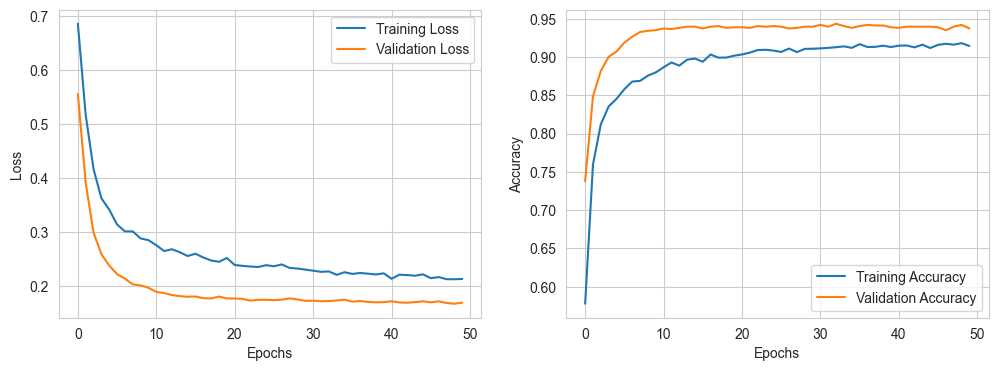

In [50]:
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, accuracy_score, precision_score

# 绘制训练和验证的损失值和准确度变化曲线
plt.figure(figsize=(12, 4))

plt.subplot(1, 2, 1)
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.show()

损失值和准确度变化曲线：

- 左图显示训练和验证损失值随epoch变化的情况。训练损失和验证损失都在下降，表明模型在学习，并且验证损失稳定在较低水平，显示出较好的泛化能力。
- 右图显示训练和验证准确度随epoch变化的情况。训练和验证准确度均在提高，验证准确度稳定在较高水平，表明模型在训练过程中没有过拟合，能够有效泛化到验证数据。

In [51]:
# 在测试集上评估模型
y_pred = (model.predict(X_test) > 0.5).astype(int)

# 计算混淆矩阵、准确度和精确度
conf_matrix = confusion_matrix(y_test, y_pred)
accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred)

print('Confusion Matrix:')
print(conf_matrix)
print(f'Accuracy: {accuracy:.2f}')
print(f'Precision: {precision:.2f}')

20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 707us/step
Confusion Matrix:
[[367  18]
 [ 29 226]]
Accuracy: 0.93
Precision: 0.93


混淆矩阵：

- True Positives (TP)：367
- False Positives (FP)：18
- True Negatives (TN)：226
- False Negatives (FN)：29

这个模型在预测一氧化碳（CO）浓度是否超过阈值方面表现相当不错。在总共640个预测中，模型正确识别了367个高于阈值的实例（真正例）和226个低于阈值的实例（真负例），总共593个正确预测，准确率达到92.66%。这表明模型在大多数情况下能够准确地区分CO浓度的高低水平。

然而，模型也出现了一些错误预测。它错误地将18个实际低于阈值的实例预测为高于阈值（假正例），同时漏掉了29个实际高于阈值的实例（假负例）。这些错误预测，特别是假负例，可能在某些应用场景中（如空气质量监测）需要特别关注，因为低估CO浓度可能带来潜在的健康风险。尽管如此，考虑到正确预测的高比例，这个模型仍然表现出了很好的性能，

性能指标：
- 准确度 (Accuracy)：0.93
- 精确度 (Precision)：0.93

这些结果表明模型在测试集上表现良好，准确度和精确度都很高，说明模型能够有效区分一氧化碳（CO）浓度是否超过阈值。

In [53]:
from sklearn.metrics import recall_score, f1_score

# 计算召回率 (Recall)
recall = recall_score(y_test, y_pred)

# 计算F1得分
f1 = f1_score(y_test, y_pred)

print(f'Recall: {recall:.2f}')
print(f'F1 Score: {f1:.2f}')

Recall: 0.89
F1 Score: 0.91


召回率是模型成功识别出正类实例的比例。较高的召回率表示模型能够识别大部分的正类实例。模型中，0.89的召回率表明大部分实际高于阈值的一氧化碳浓度都被正确分类了。

F1得分是精确率和召回率的调和平均数，综合考虑了模型的精确度和召回率。较高的F1得分表示模型在平衡精确率和召回率方面表现良好。模型的F1得分为0.91，显示了其综合性能非常好。

- 准确度 (Accuracy): 0.93
- 精确度 (Precision): 0.93
- 召回率 (Recall): 0.89
- F1得分 (F1 Score): 0.91

这些指标显示你的模型在测试集上的性能优异，能够有效区分一氧化碳浓度是否超过阈值，并且在精确度和召回率之间取得了良好的平衡。

将模型保存到本地：

In [54]:
model.save('air_quality_classification.h5')

如果要加载，则运行以下代码：

In [57]:
from tensorflow.keras.models import load_model

# 加载模型
model = load_model('air_quality_classification.h5')

## 回归模型

还是基于选择了特征变量的数据集：

In [64]:
# 读取处理后的数据
air_quality_reduced = pd.read_csv('air_quality_feature_selection.csv')

In [65]:
# 确定目标变量
target = air_quality_reduced['NOx(GT)']

# 确定输入特征
features = air_quality_reduced.drop('NOx(GT)', axis=1)

不需要生成新的变量，直接进行数据预处理：

In [66]:
# 标准化特征
scaler = StandardScaler()
features_scaled = scaler.fit_transform(features)

划分训练集，验证集和测试集：

In [67]:
# 划分训练集、验证集和测试集
X_train, X_temp, y_train, y_temp = train_test_split(features_scaled, target, test_size=0.3, random_state=42)
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.33, random_state=42)  # 0.33 * 0.3 = 0.1

In [68]:
# 确保网络参数数目不超过样本数的十分之一
num_samples = X_train.shape[0]
max_params = num_samples // 10

# 定义神经网络模型
model = Sequential()
model.add(Dense(16, input_dim=X_train.shape[1], activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(8, activation='relu'))
model.add(Dense(1))  # 输出层没有激活函数，用于回归任务

In [69]:
# 检查模型参数数量
model_params = model.count_params()
assert model_params < max_params, f"Model parameters {model_params} exceed limit {max_params}"

# 编译模型
model.compile(loss='mean_squared_error', optimizer=Adam(learning_rate=0.001), metrics=['mean_absolute_error'])

# 检查模型摘要
model.summary()

Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_6 (Dense)                 │ (None, 16)             │           160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 16)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_7 (Dense)                 │ (None, 8)              │           136 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_8 (Dense)                 │ (None, 1)              │             9 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 305 (1.19 KB)

 Trainable params: 305 (1.19 KB)

 Non-trainable params: 0 (0.00 B)

型的架构如下：

- 输入层：16个单元，ReLU激活函数
- Dropout层：0.5的dropout rate
- 隐藏层：8个单元，ReLU激活函数
- 输出层：1个单元，无激活函数（用于回归任务）

总参数数量为305个，符合样本数/10的参数数目限制。

In [70]:
# 训练模型
history = model.fit(X_train, y_train, validation_data=(X_val, y_val), epochs=50, batch_size=32)

Epoch 1/50
142/142 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 95957.3125 - mean_absolute_error: 236.2385 - val_loss: 101572.9141 - val_mean_absolute_error: 238.2182
Epoch 2/50
142/142 ━━━━━━━━━━━━━━━━━━━━ 0s 951us/step - loss: 96498.8594 - mean_absolute_error: 233.1340 - val_loss: 90478.6094 - val_mean_absolute_error: 222.0056
Epoch 3/50
142/142 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 83267.8516 - mean_absolute_error: 214.6747 - val_loss: 63415.3828 - val_mean_absolute_error: 179.9218
Epoch 4/50
142/142 ━━━━━━━━━━━━━━━━━━━━ 0s 910us/step - loss: 54394.5117 - mean_absolute_error: 165.2303 - val_loss: 31120.8828 - val_mean_absolute_error: 117.0742
Epoch 5/50
142/142 ━━━━━━━━━━━━━━━━━━━━ 0s 980us/step - loss: 24957.0684 - mean_absolute_error: 106.8862 - val_loss: 14052.9355 - val_mean_absolute_error: 76.9746
Epoch 6/50
142/142 ━━━━━━━━━━━━━━━━━━━━ 0s 962us/step - loss: 16691.3672 - mean_absolute_error: 89.1035 - val_loss: 9844.2852 - val_mean_absolute_error: 65.4056
Epoch 7/50
142/142 ━━━━

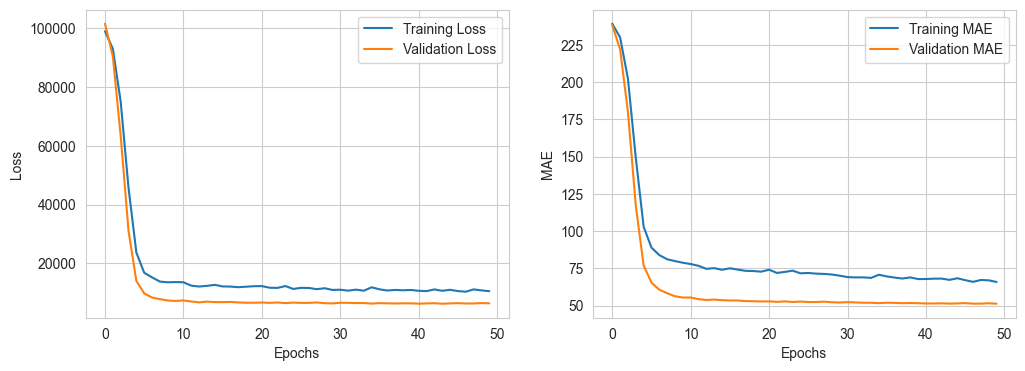

In [71]:
# 绘制训练和验证的损失值变化曲线
plt.figure(figsize=(12, 4))

plt.subplot(1, 2, 1)
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(history.history['mean_absolute_error'], label='Training MAE')
plt.plot(history.history['val_mean_absolute_error'], label='Validation MAE')
plt.xlabel('Epochs')
plt.ylabel('MAE')
plt.legend()

plt.show()

- 左图显示训练和验证损失值（均方误差）随epoch变化的情况。可以看到训练和验证损失值在训练的前几轮快速下降，之后趋于平稳，表明模型在早期学习了数据的主要特征，并在后期稳定下来，没有明显的过拟合现象。
- 右图显示训练和验证的平均绝对误差（MAE）随epoch变化的情况。训练和验证MAE也在前几轮快速下降，随后趋于稳定，同样表明模型在学习数据特征时表现良好。

注意：如果出现了Training MAE接着下降，然后Validation MAE开始上升的情况，那么就是出现了过拟合的情况，因为模型的泛化能力开始减弱了。

小幅波动可能是由于数据中的噪声或模型在这些epoch中对某些训练样本的拟合稍微过度。

接着查看模型在val data上面的actual和predicted value的比较的可视化结果：

41/41 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 


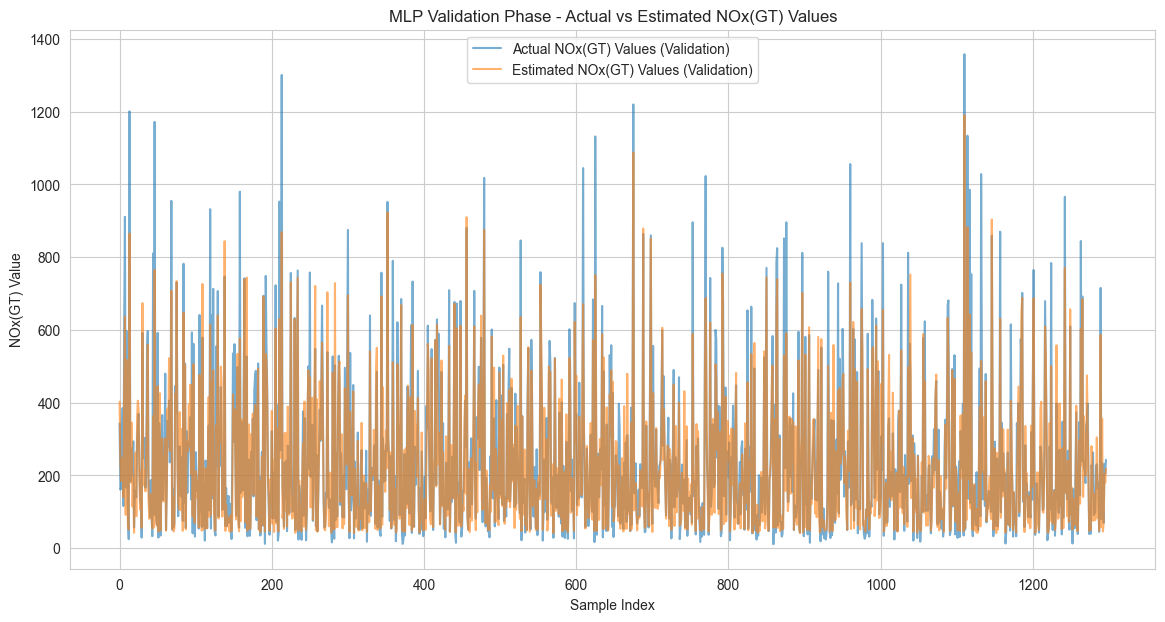

In [73]:
y_val_pred = model.predict(X_val)

# 绘制实际值和预测值的对比图
plt.figure(figsize=(14, 7))
plt.plot(y_val.values, label='Actual NOx(GT) Values (Validation)', alpha=0.6)
plt.plot(y_val_pred, label='Estimated NOx(GT) Values (Validation)', alpha=0.6)
plt.xlabel('Sample Index')
plt.ylabel('NOx(GT) Value')
plt.title('MLP Validation Phase - Actual vs Estimated NOx(GT) Values')
plt.legend()
plt.show()

从图中可以看到，橙色的预测值线条大部分时间都紧跟着蓝色的实际值线条。这表明模型在大多数情况下能够很好地预测 NOx(GT) 值，捕捉到了数据中的主要趋势。

在一些高峰和低谷处，模型的预测值与实际值仍存在一定的差距。尤其是在一些极端值（如最高点和最低点）附近，预测值可能没有完全跟上实际值的变化。这是回归模型中常见的现象，可能需要进一步的模型优化来改进。

整体上，模型的预测值与实际值的趋势是一致的，这意味着模型能够有效地捕捉到 NOx 浓度的变化模式。

In [72]:
from sklearn.metrics import mean_squared_error, mean_absolute_error

# 在测试集上评估模型
y_pred = model.predict(X_test)

# 计算性能指标
rmse = np.sqrt(mean_squared_error(y_test, y_pred))
mae = mean_absolute_error(y_test, y_pred)

print(f'RMSE: {rmse:.2f}')
print(f'MAE: {mae:.2f}')

20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 571us/step
RMSE: 79.97
MAE: 51.51


根据Assignment的要求，对于回归任务，模型需要达到以下性能指标：

- RMSE (均方根误差) ≤ 280
- MAE (平均绝对误差) ≤ 220

如果误差高于上述值，将会被记为0分。

模型的评估结果为：

- RMSE：79.97
- MAE：51.51

模型在测试集上的表现非常好，RMSE和MAE都大大低于Assignment中规定的最大误差阈值。

这表明模型能够很好地预测氮氧化物（NOx）的浓度，并且在未见数据点上的误差非常小，远低于要求。

In [74]:
# 保存训练好的回归模型
model.save('air_quality_regression.h5')

In [75]:
# 加载模型
model = load_model('air_quality_regression.h5')